# Clustering
The goal of this phase is to segment products based on their sales behavior over time, identifying groups with similar demand patterns. This supports later forecasting, inventory planning, and category decisions.


In [2]:
# Import necessary libraries
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA



In [3]:
# Get the path to the master parquet file and load the data
current = Path.cwd()
while current != current.parent:
    candidate = current / "data_cleaned" / "master.parquet"
    if candidate.exists():
        master_path = candidate
        break
    current = current.parent

df = pd.read_parquet(master_path)
df.head()

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre,Apellido,Email,...,Stock,ID_Categoria,Descripción_x,ID_Metodo,Método,Descripción_y,anio,mes,semana,ingreso
0,919,2024-01-31,10,25,5,1,Completa,Stephenie,Sexty,ssexty9@domainmarket.com,...,1640,5,"Productos congelados, como papas fritas, empan...",1,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,5,77.25
1,947,2024-01-31,106,5,1,4,Completa,Benedikta,Condon,bcondon2x@paypal.com,...,4929,1,"Productos lácteos frescos y procesados, como l...",4,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,5,5.65
2,1317,2024-01-31,235,25,3,3,Completa,Cloe,Brun,cbrun6i@theglobeandmail.com,...,1640,5,"Productos congelados, como papas fritas, empan...",3,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,1,5,46.35
3,1607,2024-01-31,114,15,5,1,Completa,Fabien,Roskam,froskam35@desdev.cn,...,4043,3,"Productos horneados frescos, como pan, factura...",1,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,5,17.55
4,2038,2024-01-31,132,2,5,4,Completa,Cassie,Corish,ccorish3n@virginia.edu,...,3358,1,"Productos lácteos frescos y procesados, como l...",4,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,5,26.05


## Aggregate Monthly Demand per Product
We extract the year and month from each transaction timestamp and aggregate the dataset to compute monthly revenue and units sold per product. This creates a time-series view of demand for each product, which is essential for detecting seasonality and demand patterns in the clustering stage.

In [4]:
# Extract year and month from date
df["anio"] = df["Fecha"].dt.year
df["mes"] = df["Fecha"].dt.month

# Aggregate demand per product per month
prod_mes = (
    df.groupby(["ID_Producto", "anio", "mes"], as_index=False)
      .agg(
          ingreso_mensual=("ingreso", "sum"),
          unidades_mensuales=("Cantidad", "sum")
      )
)

prod_mes.head()

,ID_Producto,anio,mes,ingreso_mensual,unidades_mensuales
0,1,2024,2,318.24,26
1,1,2024,3,367.20,30
2,1,2024,4,428.40,35
3,1,2024,5,171.36,14
4,1,2024,6,354.96,29


## Pivot to Product × Month Matrix
We transform the monthly aggregated data into a product × month matrix where each row represents a product and each column represents its revenue in a given month. Missing sales were filled with zeros to maintain a complete 12-month time series. 


In [5]:
# Create pivot table for product monthly income
mat_prod = prod_mes.pivot_table(
    index="ID_Producto",
    columns="mes",
    values="ingreso_mensual",
    aggfunc="sum",
    fill_value=0
)

# Sort columns in calendar order
mat_prod = mat_prod.reindex(sorted(mat_prod.columns), axis=1)

mat_prod.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12
ID_Producto,,,,,,,,,,,,
1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,220.32,440.64,379.44
2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,140.67,57.31,171.93
3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,379.06,172.30,465.21
4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,192.30,249.99,403.83
5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,101.70,192.10,96.05


## Create Derived Features (yearly revenue, monthly volability, stability indicator, margin and payment methods)

Each row represents a product, and the columns capture the key variables used for clustering:
- **Months (1–12):** Monthly revenue for detecting seasonality and peak sales periods.
- **`total_year`:** Total annual revenue.
- **`std_month`:** Volatility of monthly demand.
- **`coef_var`:** Relative variability (stability indicator).
- **Payment mix:** Share of payments made with  
  **Efectivo**, **Tarjeta de Crédito**, **Tarjeta de Débito**, **Mercado Pago**, **Transferencia**.
- **`margen`:** Estimated yearly margin.

In [6]:
mat_prod.index.name = "ID_Producto"
features = mat_prod.copy()

# Total yearly revenue for each product
features["total_year"] = features.sum(axis=1)

# Monthly volatility, this is, standard deviation of monthly revenues per product
features["std_month"] = features.iloc[:, 0:12].std(axis=1)

# Coefficient of variation (stability indicator), defined as std_month / mean_month
features["coef_var"] = features["std_month"] / (features["total_year"] / 12 + 1e-6)

features.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12,total_year,std_month,coef_var
ID_Producto,,,,,,,,,,,,,,,
1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,220.32,440.64,379.44,3378.24,135.094440,0.479875
2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,140.67,57.31,171.93,1422.33,47.445859,0.400294
3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,379.06,172.30,465.21,4617.64,160.346476,0.416697
4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,192.30,249.99,403.83,4980.57,200.760117,0.483704
5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,101.70,192.10,96.05,1695.00,65.580724,0.464288


In [22]:
# ------------------ Payment method distribution per product ----------------------------------------
# Count payment usage per product
payment_counts = (
    df.groupby(["ID_Producto", "Método_Pago"])
      .size()
      .reset_index(name="count")
)

# Convert counts → percentage per product
payment_counts["pct_pago"] = (
    payment_counts["count"] /
    payment_counts.groupby("ID_Producto")["count"].transform("sum")
)

# Pivot to wide format
payment_pivot = payment_counts.pivot(
    index="ID_Producto",
    columns="Método_Pago",
    values="pct_pago"
).fillna(0)

payment_pivot = payment_pivot.reset_index()

# Rename columns (Método codes → names)
method_labels = df[["Método_Pago", "Método"]].drop_duplicates()
rename_map = dict(zip(method_labels["Método_Pago"], method_labels["Método"]))
payment_pivot = payment_pivot.rename(columns=rename_map)

# Mergere, and avoid duplicates if cell is re-run
existing_payment_cols = [col for col in features.columns if col in rename_map.values()]
if existing_payment_cols:
    features = features.drop(columns=existing_payment_cols)

features = features.merge(payment_pivot, on="ID_Producto", how="left")


# ------------------ Add margin per product  ----------------------------------------
# Assume a fixed margin rate of 35%
df["margen"] = df["ingreso"] * 0.35
margin_prod = df.groupby("ID_Producto")["margen"].sum().reset_index()

# If running again, remove old column
if "margen" in features.columns:
    features = features.drop(columns="margen")

features = features.merge(margin_prod, on="ID_Producto", how="left")
print(features.columns)
features.head()

Index([       'ID_Producto',                    1,                    2,
                          3,                    4,                    5,
                          6,                    7,                    8,
                          9,                   10,                   11,
                         12,         'total_year',          'std_month',
                 'coef_var',           'Efectivo', 'Tarjeta de Crédito',
        'Tarjeta de Débito',       'Mercado Pago',      'Transferencia',
                   'margen'],
      dtype='object')


,ID_Producto,1,2,3,4,5,6,7,8,9,...,12,total_year,std_month,coef_var,Efectivo,Tarjeta de Crédito,Tarjeta de Débito,Mercado Pago,Transferencia,margen
0,1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,...,379.44,3378.24,135.094440,0.479875,0.197531,0.074074,0.197531,0.185185,0.345679,1182.3840
1,2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,...,171.93,1422.33,47.445859,0.400294,0.207317,0.073171,0.268293,0.256098,0.195122,497.8155
2,3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,...,465.21,4617.64,160.346476,0.416697,0.214286,0.059524,0.095238,0.333333,0.297619,1616.1740
3,4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,...,403.83,4980.57,200.760117,0.483704,0.194805,0.077922,0.168831,0.311688,0.246753,1743.1995
4,5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,...,96.05,1695.00,65.580724,0.464288,0.162500,0.062500,0.175000,0.325000,0.275000,593.2500


## Standardize Data
To ensure that all variables contribute fairly to the clustering process, the features were standardized using StandardScaler. Since K-means and similar algorithms rely on distance calculations, variables with larger numerical ranges, such as annual revenue, would dominate the clustering and overshadow smaller-scale variables like volatility or the coefficient of variation. By transforming all features to have mean 0 and standard deviation 1, the model evaluates patterns based on behavior rather than scale.

In [26]:
# Remove ID from scaling
id_col = features["ID_Producto"]
X = features.drop(columns=["ID_Producto"]).values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Rebuild DataFrame
features_scaled = pd.DataFrame(
    X_scaled,
    index=features.index,
    columns=features.drop(columns=["ID_Producto"]).columns
)
# Add ID column 
features_scaled["ID_Producto"] = id_col.values

features_scaled.head()

,1,2,3,4,5,6,7,8,9,10,...,total_year,std_month,coef_var,Efectivo,Tarjeta de Crédito,Tarjeta de Débito,Mercado Pago,Transferencia,margen,ID_Producto
0,-0.307541,0.484480,0.608786,1.361703,-0.428117,0.524792,0.733454,-0.447787,-0.290752,-0.124986,...,0.415478,0.297563,-0.588728,0.395862,-0.564619,0.393862,-2.005090,1.669085,0.415478,1
1,0.881752,-0.733956,-0.732350,-0.857990,-0.668146,-0.841813,-0.905687,-0.607266,-0.205623,-0.666060,...,-0.806536,-1.051502,-1.593980,0.661549,-0.607980,1.851947,-0.638612,-1.390977,-0.806536,2
2,2.052326,1.562867,2.107108,1.613730,1.186991,1.211207,-0.051713,0.444473,0.932985,0.953355,...,1.189831,0.686236,-1.386779,0.850742,-1.263035,-1.713935,0.849719,0.692269,1.189831,3
3,-0.307541,1.992951,1.281042,2.641758,0.929211,2.864395,0.841900,0.727392,1.251206,-0.315330,...,1.416582,1.308273,-0.540362,0.321863,-0.379914,-0.197511,0.432620,-0.341575,1.416582,4
4,-0.049595,-0.690964,-0.929616,-0.410902,0.121833,-0.770588,-0.674774,-0.224240,-0.327471,-0.930788,...,-0.636178,-0.772375,-0.785617,-0.555196,-1.120177,-0.070399,0.689136,0.232539,-0.636178,5


## Determine Optimal Number of Clusters (Elbow + Silhouette)

In [27]:
inertias = []
silhouettes = []
k_values = range(2, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

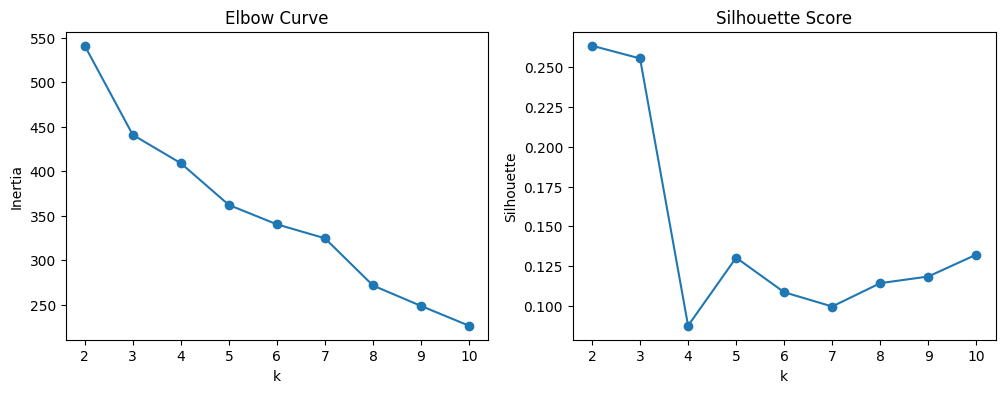

In [28]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_values, silhouettes, marker="o")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")

plt.show()

- The Elbow Curve shows a clear inflection at k = 3, indicating diminishing returns in inertia reduction beyond this point.
- The Silhouette Score is highest at k = 2, but the value for k = 3 remains strong and much higher than k ≥ 4, where the score drops sharply.

Considering both metrics together, and balancing separation quality with practical interpretability, the selected number of clusters is: k = 3.

## Run Final K-Means 

In [35]:
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_scaled)
features["cluster"] = labels

# Key cluster metrics
cluster_profile = (
    features.groupby("cluster")[
        ["total_year", "std_month", "coef_var",
         "Efectivo", "Tarjeta de Crédito", "Tarjeta de Débito",
         "Mercado Pago", "Transferencia", "margen"]
    ]
    .mean()
)

# Monthly pattern
monthly_cols = list(range(1,13))
cluster_month_pattern = (
    features.groupby("cluster")[monthly_cols]
    .mean()
)

cluster_assignments = features[["ID_Producto", "cluster"]]
cluster_assignments.head(20)



,ID_Producto,cluster
0,1,1
1,2,0
2,3,1
3,4,1
4,5,0
5,6,2
6,7,1
7,8,1
8,9,1
9,10,1


## Heatmap of Monthly Patterns

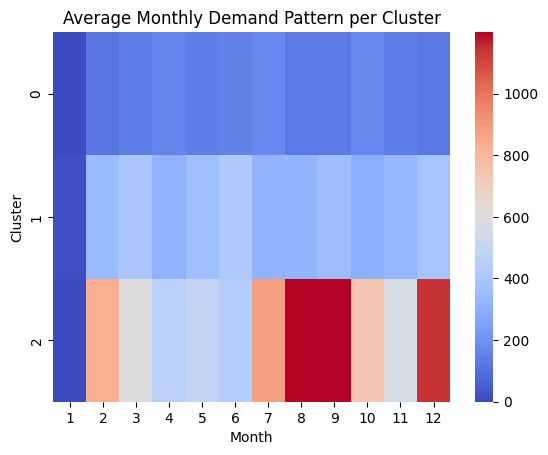

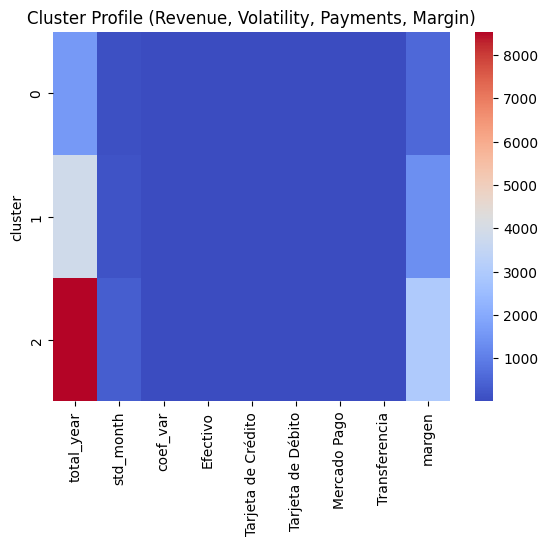

In [38]:
sns.heatmap(cluster_month_pattern, annot=False, cmap="coolwarm")
plt.title("Average Monthly Demand Pattern per Cluster")
plt.xlabel("Month")
plt.ylabel("Cluster")
plt.show()

sns.heatmap(cluster_profile, annot=False, cmap="coolwarm")
plt.title("Cluster Profile (Revenue, Volatility, Payments, Margin)")
plt.show()

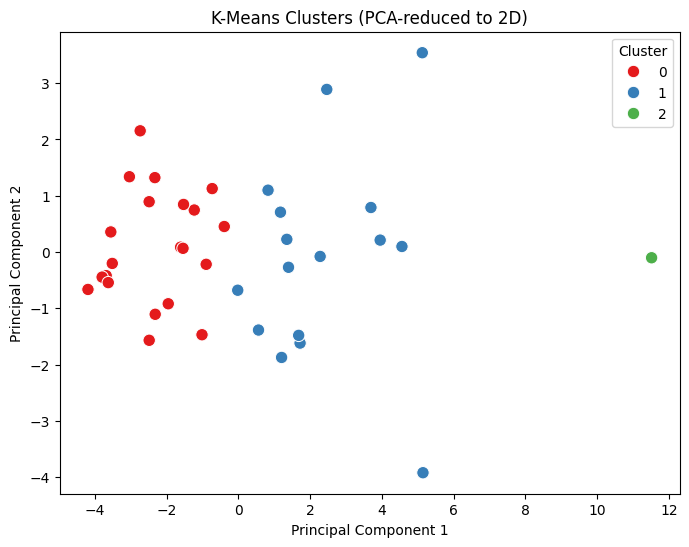

In [37]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": features["cluster"]
})

# ---- Scatterplot ----
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette="Set1",
    s=80
)
plt.title("K-Means Clusters (PCA-reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [ ]:
# Identify singleton clusters and their products
print("Cluster Distribution:")
print(features["cluster"].value_counts().sort_index())
print("\n" + "="*80)

for cluster_id in sorted(features["cluster"].unique()):
    cluster_products = features[features["cluster"] == cluster_id]
    print(f"\nCluster {cluster_id}: {len(cluster_products)} products")
    print("-" * 80)
    
    if len(cluster_products) == 1:
        print("SINGLETON CLUSTER - Star Product(s):")
        product_info = cluster_products[["ID_Producto", "total_year", "std_month", "coef_var"]].iloc[0]
        print(f"  ID_Producto: {product_info['ID_Producto']}")
        print(f"  Annual Revenue: ${product_info['total_year']:,.2f}")
        print(f"  Monthly Volatility (Std Dev): ${product_info['std_month']:,.2f}")
        print(f"  Coefficient of Variation: {product_info['coef_var']:.3f}")
        print(f"  Margin: ${cluster_products['margen'].iloc[0]:,.2f}")
        print("\nMonthly Revenue:")
        monthly_data = cluster_products[list(range(1, 13))].iloc[0]
        for month, revenue in monthly_data.items():
            print(f"    Month {month}: ${revenue:,.2f}")
    else:
        print(f"Top 5 products by revenue:")
        top_products = cluster_products.nlargest(5, "total_year")[["ID_Producto", "total_year", "std_month", "coef_var"]]
        print(top_products.to_string())